In [1]:
#Basic imports
import sys
import collections
import random

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import statsmodels.api as sm

DATA_DIR = "/dfs/scratch0/googlengrams/2012-eng-fic/"
MISC_DIR = "/dfs/scratch0/googlengrams/misc"
sys.path.append("../langchange")

import ioutils as util
import seaborn as sns
from cooccurrence import matstore
from statutils import plothelper, changepoint, trendestimator, seriesanalysis, mixedmodels
from vecanalysis.sequentialexplicit import SequentialExplicit

%matplotlib inline

In [348]:
plt.rcParams["font.sans-serif"].insert(0, "Helvectica")

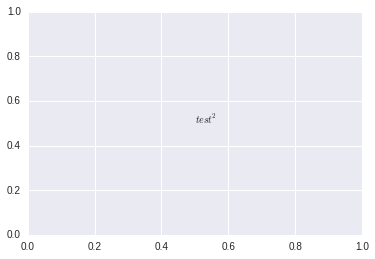

In [8]:
plt.text(.5, 0.5, r"$test^2$")

In [9]:
# Loading basic word and frequency info
year_words = util.load_pickle(DATA_DIR + "/info/freqnonstop_peryear-1900-2000-7.pkl")
years = np.arange(1900, 2001)
freqs = util.load_pickle(DATA_DIR + "/info/freqnonstop_peryear-1900-2000-7-freqs.pkl")
# top year words contains only top 20000 words per year
top_year_words = {}
for year, words in year_words.iteritems():
    top_year_words[year] = words[:10000]
all_words = set([word for year_words in top_year_words.values() for word in year_words])
year_freqs = collections.defaultdict(lambda : collections.defaultdict(lambda : float('nan')))
for year, words in top_year_words.iteritems():
    for word in words:
        year_freqs[word][year] = freqs[word][year]

# Load word lists
brown = util.load_word_list(MISC_DIR + "/brownwords.txt")
concrete = util.load_word_list(MISC_DIR + "/concretewords.txt")
abstract = util.load_word_list(MISC_DIR "/abstractwords.txt")
concrete_cmn = util.load_word_list(MISC_DIR + "/concretewords-cmn.txt")
abs_cmn = util.load_word_list(MISC_DIR + "/abstractwords-cmn.txt")
nouns = util.load_word_list(MISC_DIR + "/nouns.txt")
adjs = util.load_word_list(MISC_DIR + "/adjs.txt")
verbs = util.load_word_list(MISC_DIR + "/misc/verbs.txt")
advs = util.load_word_list(MISC_DIR + "/advs.txt")

In [11]:
import dill
con_scores = dill.load(open(DATA_DIR + "/nppmi_conf/lsmooth10/netstats/conscores-10.pkl", "r"))
con_scores_ms = seriesanalysis.get_series_mean_std(con_scores, con_scores.keys())

In [15]:
vols_ms = seriesanalysis.get_series_mean_std(vols, vols.keys(), start_year=1901)

In [157]:
# Old yearly word stats
sums = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/netstats/freqnonstop_peryear-1900-2000-7-top20000-sum.pkl")
clusts = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/netstats/freqnonstop_peryear-1900-2000-7-top20000-weighted.pkl")
vols =  util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/volstats/freqnonstop_peryear-1900-2000-7-0.0-top20000-vols.pkl")
cents = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/secondnetstats-0-None/freqnonstop_peryear-1900-2000-7-top20000-sum.pkl")
knn_sums = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/secondnetstats-0-5/freqnonstop_peryear-1900-2000-7-top20000-sum.pkl")
disps =  util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/volstats/freqnonstop_peryear-1900-2000-7-0.0-top20000-disps.pkl")

In [158]:
# log transform of variables as necessary
log_sums = {word:{year:np.log(sum) for year, sum in vals.iteritems()} for word, vals in sums.iteritems()}
log_clusts = {word:{year:np.log(clust) for year, clust in vals.iteritems()} for word, vals in clusts.iteritems()}
log_cents = {word:{year:np.log(cent) for year, cent in vals.iteritems()} for word, vals in cents.iteritems()}


In [196]:
log_knn_sums = {word:{year:np.log(sum) for year, sum in vals.iteritems()} for word, vals in knn_sums.iteritems()}

In [159]:
log_freqs = collections.defaultdict(lambda : collections.defaultdict(lambda : float('nan')))
for word, vals in year_freqs.iteritems():
    for year, freq in vals.iteritems():
        log_freqs[word][year] = np.log(freq)

In [160]:
# medians of variables as necessary
log_freqs_med = seriesanalysis.get_series_mean_std_peryear(log_freqs, top_year_words)[0]
#log_degs_med = seriesanalysis.get_series_median_peryear(log_degs, top_year_words)
log_sums_med = seriesanalysis.get_series_mean_std_peryear(log_sums, top_year_words)[0]
log_clusts_med = seriesanalysis.get_series_mean_std_peryear(log_clusts, top_year_words)[0]
log_cents_med = seriesanalysis.get_series_mean_std_peryear(log_cents, top_year_words)[0]


In [201]:
log_knn_sums_med = seriesanalysis.get_series_mean_std_peryear(log_knn_sums, top_year_words)[0]

In [330]:
# setting up dataframe
random.seed(10)
# keep words that have valid volatility scores and second order centralities
valid_set = (set(vols.keys()).intersection(set(cents.keys()))).intersection(set(brown))
noun_set = set(nouns)
verb_set = set(verbs)
adj_set = set(adjs)
adv_set = set(advs)
con_set = set(concrete)
abs_set = set(abstract)
valid_list = list(valid_set)
random.shuffle(valid_list)
from functools import partial
def diff_op(feat_func, word, year, forward=True):
    base_year = year 
    diff_year = year - 1
    if forward:
        base_year += 1 
        diff_year += 1
    return feat_func(word, base_year) - feat_func(word, diff_year)
feature_dict = {"freq" : (lambda word, year : log_freqs[word][year-1] - log_freqs_med[year-1901]),
             #   "freq_diff" :  partial(diff_op, lambda word, year : log_freqs[word][year-1] - log_freqs_med[year-1901]),
                "freq_type" : (lambda word, year : 1 if log_freqs[word][year] - log_freqs_med[year-1900] - log_freqs[word][year-1] + log_freqs_med[year-1901] > 0 else -1),
                "extent" : (lambda word, year : log_sums[word][year-1] - log_sums_med[year-1901]),
             #   "extent_diff" : partial(diff_op, lambda word, year : log_sums[word][year-1] - log_sums_med[year-1901]),
                "centr" : (lambda word, year : log_cents[word][year-1] - log_cents_med[year-1901]),
             #   "centr_diff" : partial(diff_op, lambda word, year : log_cents[word][year-1] - log_cents_med[year-1901]),
                "clust" : (lambda word, year : log_clusts[word][year-1] - log_clusts_med[year-1901]),
             #   "clust_diff" : partial(diff_op, lambda word, year : log_clusts[word][year-1] - log_clusts_med[year-1901]),
             #   "clust_diff2" : partial(diff_op, lambda word, year : log_clusts[word][year-1] - log_clusts_med[year-1901], forward=False),
              #   "knn_sum" : (lambda word, year : log_knn_sums[word][year-1] - log_knn_sums_med[year-1901]),
              #  "con" : (lambda word, year : 1 if word in con_set else -1 if word in abs_set else 0),
                "con_s" : (lambda word, year : (con_scores[word][year-1] -  con_scores_ms[0][year-1901]) / (con_scores_ms[1][year-1901])),
              #  "con_s_diff" : partial(diff_op, lambda word, year : (con_scores[word][year-1] -  con_scores_ms[0][year-1901]) / (con_scores_ms[1][year-1901])),
                "vol" : (lambda word, year : (1 - vols[word][year])),
                "vol_m" : (lambda word, year : (1 - vols[word][year]) - (1 - vols_ms[0][year-1901])),
                "disp" : (lambda word, year : (1 - disps[word][year])),
              #  "lag_vol" : (lambda word, year : (1 - vols[word][year-1])), no lagged vol unless really necessary
                "verb" : (lambda word, year : 1 if word in verb_set else 0),
                "noun" : (lambda word, year : 1 if word in noun_set else 0),
                "adv" : (lambda word, year : 1 if word in adj_set else 0),
                "adj" : (lambda word, year : 1 if word in adv_set else 0),
                "pos" : (lambda word, year : "adj" if word in adj_set else "verb" if word in verb_set else "adv" if word in adv_set else "noun"),
                }
temp_df = mixedmodels.make_data_frame(valid_list, range(1901, 2001), feature_dict)

In [331]:
len(temp_df["word"].unique())

10654

In [240]:
succ =  trendestimator.get_successful_new_words(year_freqs, s_buff=10, e_buff=10, not_present_min=0.1)
bad_succ = set(util.load_word_list("/dfs/scratch0/googlengrams/misc/succ-new-words.txt"))
succ = {word:year for word, year in succ.iteritems() if not word in bad_succ}

In [271]:
succ_con = []
for word, year, in succ.iteritems():
    for i_year in range(year, year+10):
        succ_con.append(con_scores[word][i_year] - con_scores_ms[0][i_year-1900])

In [274]:
succ_con = [val for val in succ_con if not np.isnan(val)]

In [276]:
sp.stats.mannwhitneyu(temp_df.loc[~temp_df["word"].isin(succ.keys())]["con_s"],temp_df.loc[temp_df["word"].isin(succ.keys())]["con_s"])

(6185932194.0, 0.0)

In [310]:
bott = abs(temp_df.loc[~temp_df["word"].isin(succ.keys())]["con_s"].max())

In [312]:
base = -1*temp_df.loc[~temp_df["word"].isin(succ.keys())]["con_s"].median()
new = -1*temp_df.loc[temp_df["word"].isin(succ.keys())]["con_s"].median()

In [313]:
(new-base)/bott

-0.08940265635685142

In [21]:
year_vocs = []
for year in range(1901, 2001):
    year_vocs.append(len(temp_df.loc[temp_df["year"] == year]["word"].unique()))

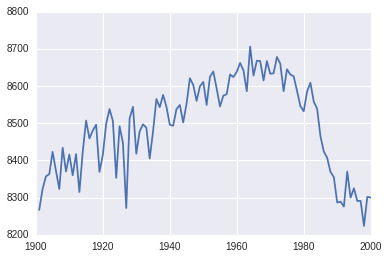

In [22]:
plt.plot(range(1901, 2001), year_vocs)

In [23]:
np.mean(year_vocs)

8493.2999999999993

In [24]:
np.std(year_vocs)

122.39456687288043

In [124]:
con_scores_fp = open("/dfs/scratch0/googlengrams/misc/concreteness_ratings.csv")
scores = []
stds = []
con_scores_fp.readline()
for line in con_scores_fp:
    info = line.split(",")
    scores.append(float(info[2]))
    stds.append(float(info[3]))
scores = np.array(scores)
stds = np.array(stds)
scores = np.abs(scores - scores.mean())
sp.stats.spearmanr(stds, scores)

(-0.82655394241747515, 0.0)

In [267]:
sp.stats.pearsonr(train_df["freq_diff"], train_df["freq"])

(0.08403717416311085, 0.0)

In [344]:
feature_dict = {
                "vol" : (lambda word, year : (1 - vols[word][year])),
                "disp" : (lambda word, year : (1 - disps[word][year])),
                "clust" : (lambda word, year : (log_clusts[word][year] - log_clusts_med[year-1900]) if word in log_clusts else np.nan),
                }
full_df = mixedmodels.make_data_frame(vols.keys(), range(1902, 2001), feature_dict)

In [162]:
# making train, dev, test split
kept_words = temp_df["word"].unique()
num_valtest = int((len(kept_words)) * 0.1)
test_df = temp_df.loc[temp_df["word"].isin(kept_words[:num_valtest])]
dev_df = temp_df.loc[temp_df["word"].isin(kept_words[num_valtest:2*num_valtest])]
train_df = temp_df.loc[temp_df["word"].isin(kept_words[2*num_valtest:])]

In [163]:
ztrain_df = train_df.copy()
for column in ztrain_df.columns:
    if column in set(["freq",  "con_s", "extent", "centr", "clust", "vol"]):
        ztrain_df[column] = sp.stats.zscore(ztrain_df[column])

In [164]:
ztemp_df = temp_df.copy()
for column in ztemp_df.columns:
    if column in set(["freq", "freq_diff", "con_s", "extent", "centr", "clust", "vol", "con_s_diff", "clust_diff", "extent_diff", "centr_diff"]):
        ztemp_df[column] = sp.stats.zscore(ztemp_df[column])

In [69]:
ztest_df = test_df.copy()
for column in ztest_df.columns:
    if column in set(["freq", "freq_diff", "con_s", "extent", "centr", "clust", "vol"]):
        ztest_df[column] = sp.stats.zscore(ztest_df[column])

In [332]:
# makeing training data frame with unregularized values, for visualization purposes etc. 
feature_dict = {"freq" : (lambda word, year : log_freqs[word][year-1]),
              #  "freq_diff" :  partial(diff_op, lambda word, year : log_freqs[word][year-1]),
                "freq_type" : (lambda word, year : 1 if log_freqs[word][year] - log_freqs_med[year-1900] - log_freqs[word][year-1] + log_freqs_med[year-1901] > 0 else -1),
                "extent" : (lambda word, year : log_sums[word][year-1]),
                "deg" : (lambda word, year : log_degs[word][year-1]),
         #       "extent_diff" : partial(diff_op, lambda word, year : log_sums[word][year-1] - log_sums_med[year-1901]),
                "centr" : (lambda word, year : log_cents[word][year-1]),
              #  "centr_diff" : partial(diff_op, lambda word, year : log_cents[word][year-1] - log_cents_med[year-1901]),
                "clust" : (lambda word, year : log_clusts[word][year-1]),
              #  "clust_diff" : partial(diff_op, lambda word, year : log_clusts[word][year-1] - log_clusts_med[year-1901]),
              #  "clust_diff2" : partial(diff_op, lambda word, year : log_clusts[word][year-1] - log_clusts_med[year-1901], forward=False),
                #  "knn_sum" : (lambda word, year : log_knn_sums[word][year-1] - log_knn_sums_med[year-1901]),
                "con" : (lambda word, year : 1 if word in con_set else -1 if word in abs_set else 0),
                "con_s" : (lambda word, year : (con_scores[word][year-1] -  con_scores_ms[0][year-1901]) / (con_scores_ms[1][year-1901])),
              #  "con_s_diff" : partial(diff_op, lambda word, year : (con_scores[word][year-1] -  con_scores_ms[0][year-1901]) / (con_scores_ms[1][year-1901])),
                "vol" : (lambda word, year : (1 - vols[word][year])),
                "vol_m" : (lambda word, year : (1 - vols[word][year]) - (1 - vols_ms[0][year-1901])),
                "disp" : (lambda word, year : (1 - disps[word][year])),
              #  "lag_vol" : (lambda word, year : (1 - vols[word][year-1])), no lagged vol unless really necessary
                "verb" : (lambda word, year : 1 if word in verb_set else 0),
                "noun" : (lambda word, year : 1 if word in noun_set else 0),
                "adv" : (lambda word, year : 1 if word in adj_set else 0),
                "adj" : (lambda word, year : 1 if word in adv_set else 0),
                "pos" : (lambda word, year : "adj" if word in adj_set else "verb" if word in verb_set else "adv" if word in adv_set else "noun")
                }
noreg_train_df = mixedmodels.make_data_frame(train_df["word"].unique(), range(1901, 2001), feature_dict)
noreg_full_df = mixedmodels.make_data_frame(temp_df["word"].unique(), range(1901, 2001), feature_dict)

In [333]:
print len(noreg_train_df), len(train_df)

679500 679500


In [64]:
np.percentile(np.exp(noreg_full_df["freq"]), 1)

1.8219149045470843e-06

In [208]:
np.sum(np.temp_df["freq"])

(0.82798788863450168, 0.0)

In [575]:
def make_feat_series(df, feat):
    return lambda word : (df.loc[df["word"] == word]).sort("year")[feat].as_matrix().flatten()
con_series = make_feat_series(ztemp_df, "con_s")
vol_series = make_feat_series(ztemp_df, "vol_m")
disp_series = make_feat_series(ztemp_df, "disp")
clust_series = make_feat_series(ztemp_df, "clust")
centr_series = make_feat_series(ztemp_df, "centr")
freq_series = make_feat_series(ztemp_df, "freq")
breadth_series = lambda word : -0.108 * clust_series(word) + 0.063 * centr_series(word) - 0.015 * con_series(word)

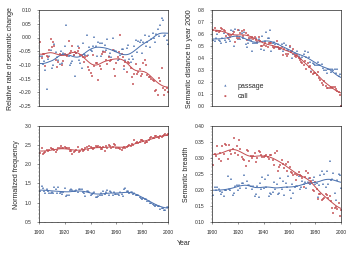

In [576]:
plt.rcParams["figure.figsize"] = (5, 3.5)
#plt.rcParams["font.family"] = "Helvetica"
sns.set_style("white")
plt.rcParams["lines.linewidth"] = 0.25
plt.rcParams["patch.linewidth"] = 0.25
plt.rcParams["grid.linewidth"] = 0.6
plt.rcParams["axes.linewidth"] = 0.6
plt.rcParams["axes.labelsize"] =  7
plt.rcParams["axes.titlesize"] = 7
plt.rcParams["xtick.labelsize"] = 5
plt.rcParams["ytick.labelsize"] = 5
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["ytick.minor.size"] = 1
plt.rcParams["xtick.minor.width"] = 0.25
plt.rcParams["ytick.minor.width"] = 0.25
plt.rcParams["legend.fontsize"] = 7
s = 3
fig, axs = plt.subplots(2,2, sharex=True)
a = plothelper.plot_smooth(np.arange(1901, 2001), vol_series("passage"), color=sns.color_palette()[0], ax=axs[0,0], marker='^', s=s)
b = plothelper.plot_smooth(np.arange(1901, 2001), vol_series("call"), color=sns.color_palette()[2], ax=axs[0,0], s=s)
a = plothelper.plot_smooth(np.arange(1901, 2001), disp_series("passage"), color=sns.color_palette()[0], ax=axs[0,1], marker='^',s=s)
b = plothelper.plot_smooth(np.arange(1901, 2001), disp_series("call"), color=sns.color_palette()[2], ax=axs[0,1], s=s)
#c = plothelper.plot_smooth(np.arange(1902, 2001), vol_series("queer"), color=sns.color_palette()[1], ax=axs[0])
axs[0,0].set_xlim(1900, 2000)
axs[1,0].set_xlim(1900, 2000)
axs[0,1].set_xlim(1900, 2000)
axs[1,1].set_xlim(1900, 2000)
axs[0,1].set_ylim(0, 0.8)
#axs[0].set_ylim(0.0, 1.0)
axs[0,1].legend((a,b), ["passage", "call"], loc='lower left')
a = plothelper.plot_smooth(np.arange(1901, 2001), freq_series("passage"), color=sns.color_palette()[0], ax=axs[1,0], marker='^', s=s)
b = plothelper.plot_smooth(np.arange(1901, 2001), freq_series("call"), color=sns.color_palette()[2], ax=axs[1,0], s=s)
plothelper.plot_smooth(np.arange(1901, 2001), breadth_series("passage"), color=sns.color_palette()[0], ax=axs[1,1], marker='^', s=s)
plothelper.plot_smooth(np.arange(1901, 2001), breadth_series("call"), color=sns.color_palette()[2], ax=axs[1,1], s=s)
#plothelper.plot_smooth(np.arange(1901, 2001), disp_series("harassed"), color=sns.color_palette()[1], ax=axs[1])
#axs[1].set_ylim(0.1, 0.3)
axs[0,0].set_ylabel("Relative rate of semantic change")
axs[0,1].set_ylabel("Semantic distance to year 2000")
axs[1,0].set_ylabel("Normalized frequency")
axs[1,1].set_ylabel("Semantic breadth")
#fig.text(0.1, 0.92, 'a', weight="bold", fontsize=11)
#fig.text(0.595, 0.92, 'b', weight="bold", fontsize=11)
#fig.text(0.1, 0.45, 'c', weight="bold", fontsize=11)
#fig.text(0.595, 0.45, 'd', weight="bold", fontsize=11)
fig.text(0.5, 0, "Year", fontsize=7)
#axs[0].set_xlabel("Year")
#axs[1].set_xlabel("Year")
for ax_1 in [0,1]:
    for ax_2 in [0,1]:
        axs[ax_1, ax_2].minorticks_on()
        for axis in ['top','bottom','left','right']:
            axs[ax_1, ax_2].spines[axis].set_linewidth(0.7)
        if ax_1 == 1:
            axs[ax_1, ax_2].xaxis.set_ticks_position('bottom')
        else:
            axs[ax_1, ax_2].xaxis.set_ticks_position('none')
        axs[ax_1, ax_2].yaxis.set_ticks_position('left')
plt.tight_layout()
plt.savefig("casestudy-resextend.pdf")
#plt.legend(["dog", "gay", "harassed"], loc='upper left')

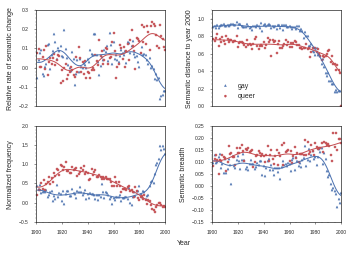

In [577]:
plt.rcParams["figure.figsize"] = (5, 3.5)
sns.set_style("white")
plt.rcParams["lines.linewidth"] = 0.25
plt.rcParams["patch.linewidth"] = 0.25
plt.rcParams["grid.linewidth"] = 0.6
plt.rcParams["axes.linewidth"] = 0.6
plt.rcParams["axes.labelsize"] =  7
plt.rcParams["axes.titlesize"] = 7
plt.rcParams["xtick.labelsize"] = 5
plt.rcParams["ytick.labelsize"] = 5
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["ytick.minor.size"] = 1
plt.rcParams["xtick.minor.width"] = 0.25
plt.rcParams["ytick.minor.width"] = 0.25
plt.rcParams["legend.fontsize"] = 7
s = 5
fig, axs = plt.subplots(2,2, sharex=True)
a = plothelper.plot_smooth(np.arange(1901, 2001), vol_series("gay"), color=sns.color_palette()[0], ax=axs[0,0], marker='^', s=s)
b = plothelper.plot_smooth(np.arange(1901, 2001), vol_series("queer"), color=sns.color_palette()[2], ax=axs[0,0], s=s)
a = plothelper.plot_smooth(np.arange(1901, 2001), disp_series("gay"), color=sns.color_palette()[0], ax=axs[0,1], marker='^',s=s)
b = plothelper.plot_smooth(np.arange(1901, 2001), disp_series("queer"), color=sns.color_palette()[2], ax=axs[0,1], s=s)
#c = plothelper.plot_smooth(np.arange(1902, 2001), vol_series("queer"), color=sns.color_palette()[1], ax=axs[0])
axs[0,0].set_xlim(1900, 2000)
axs[1,0].set_xlim(1900, 2000)
axs[0,1].set_xlim(1900, 2000)
axs[1,1].set_xlim(1900, 2000)
axs[0,1].set_ylim(0, 1.1)
axs[0,1].legend((a,b), ["gay", "queer"], loc='lower left')
a = plothelper.plot_smooth(np.arange(1901, 2001), freq_series("gay"), color=sns.color_palette()[0], ax=axs[1,0], marker='^', s=s)
b = plothelper.plot_smooth(np.arange(1901, 2001), freq_series("queer"), color=sns.color_palette()[2], ax=axs[1,0], s=s)
plothelper.plot_smooth(np.arange(1901, 2001), breadth_series("gay"), color=sns.color_palette()[0], ax=axs[1,1], marker='^', s=s)
plothelper.plot_smooth(np.arange(1901, 2001), breadth_series("queer"), color=sns.color_palette()[2], ax=axs[1,1], s=s)
#plothelper.plot_smooth(np.arange(1901, 2001), disp_series("harassed"), color=sns.color_palette()[1], ax=axs[1])
#axs[1].set_ylim(0.1, 0.3)
axs[0,0].set_ylabel("Relative rate of semantic change")
axs[0,1].set_ylabel("Semantic distance to year 2000")
axs[1,0].set_ylabel("Normalized frequency")
axs[1,1].set_ylabel("Semantic breadth")
#fig.text(0.1, 0.92, 'a', weight="bold", fontsize=11)
#fig.text(0.595, 0.92, 'b', weight="bold", fontsize=11)
#fig.text(0.1, 0.45, 'c', weight="bold", fontsize=11)
#fig.text(0.595, 0.45, 'd', weight="bold", fontsize=11)
fig.text(0.5, 0, "Year", fontsize=7)
#axs[0].set_xlabel("Year")
#axs[1].set_xlabel("Year")
for ax_1 in [0,1]:
    for ax_2 in [0,1]:
        axs[ax_1, ax_2].minorticks_on()
        for axis in ['top','bottom','left','right']:
            axs[ax_1, ax_2].spines[axis].set_linewidth(0.7)
        if ax_1 == 1:
            axs[ax_1, ax_2].xaxis.set_ticks_position('bottom')
        else:
            axs[ax_1, ax_2].xaxis.set_ticks_position('none')
        axs[ax_1, ax_2].yaxis.set_ticks_position('left')
plt.tight_layout()
plt.savefig("casestudy-cult.pdf")

In [377]:
word = "odious"
print (0.06 * centr_series(word) - 0.1 * clust_series(word) - 0.001 * con_series(word) - 0.5*freq_series(word))[-1]

0.548602286673


In [59]:
trendestimator.trend_estimate_arr(vol_series("dull")).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     36.17
Date:                Fri, 02 Oct 2015   Prob (F-statistic):           3.12e-08
Time:                        14:20:24   Log-Likelihood:                 213.49
No. Observations:                 100   AIC:                            -423.0
Df Residuals:                      98   BIC:                            -417.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0226      0.006     -3.939      0.000        -0.034    -0.011
x1             0.0006      0.000      6.014      0.000         0.000     0.001
==============================================================================
Omnibus:                        4.157   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                3.674
Skew:                          -0.463   Prob(JB):                        0.159
Kurtosis:                       3.158   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [421]:
clust_w_trends = trendestimator.get_trend_estimates({word:{year:(val - log_clusts_med[year-1900]) for year, val in series.iteritems()} for word, series in log_clusts.iteritems()}, start_year=1902)
processed_wclust = trendestimator.process_trend_estimates(clust_w_trends, {word:year_freqs[word][2000] for word in year_freqs.keys()}
                                                          , slope_thresh=0)

In [452]:
vol_trends = trendestimator.get_trend_estimates({word:{year:(val - vols_ms[0][year-1901]) for year, val in series.iteritems()} for word, series in vols.iteritems()}, start_year=1902)
processed_vol = trendestimator.process_trend_estimates(vol_trends, {word:year_freqs[word][2000] for word in year_freqs.keys()}
                                                          , slope_thresh=0)

In [462]:
inc_vol = set([entry for entry in processed_vol["decreasing"]])

In [389]:
(noreg_train_df.loc[noreg_train_df["year"]==2000]).sort(["freq"])[200:250]

,adj,adv,centr,clust,con,con_s,deg,disp,extent,freq,freq_type,noun,pos,verb,vol,vol_m,word,year
620699,0,0,4.452447,-4.610607,-1,-0.133445,3.496508,-2.220446e-16,2.246621,-13.264358,1,0,verb,1,0.266871,-0.022050,welcoming,2000
546799,0,0,4.224669,-4.792610,0,-0.479698,3.135494,0.000000e+00,1.871343,-13.263973,1,1,noun,0,0.236163,-0.052758,clues,2000
844699,1,0,5.512744,-4.010141,-1,-0.825951,3.258097,1.110223e-16,1.828741,-13.263588,1,0,adv,0,0.249170,-0.039751,uncertainly,2000
480199,0,0,4.579413,-5.003314,0,0.212808,3.784190,0.000000e+00,2.551493,-13.263204,-1,0,verb,1,0.305558,0.016636,signing,2000
564799,0,1,4.486252,-4.349972,0,-0.479698,3.401197,0.000000e+00,2.101205,-13.263204,-1,0,adj,0,0.561377,0.272455,downcast,2000
232599,0,0,4.710832,-5.193707,0,1.597820,3.850148,0.000000e+00,2.621306,-13.262819,-1,1,noun,0,0.332153,0.043232,burns,2000
466799,0,0,4.324678,-5.321154,1,0.905314,4.127134,-2.220446e-16,2.932954,-13.262435,-1,1,noun,0,0.446437,0.157515,troop,2000
239699,0,0,4.827395,-5.885235,-1,-0.479698,4.219508,0.000000e+00,2.952847,-13.261667,-1,0,verb,1,0.420450,0.131529,striving,2000
435199,0,1,4.523753,-3.746242,-1,-0.479698,3.761200,0.000000e+00,2.531324,-13.260899,1,0,adj,0,0.328647,0.039725,arrogant,2000
715999,0,0,4.717959,-5.247603,0,-0.133445,4.430817,-2.220446e-16,3.195168,-13.260132,-1,1,noun,0,0.390808,0.101887,airs,2000


In [456]:
vol_trends["cultural"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     25.44
Date:                Sun, 06 Sep 2015   Prob (F-statistic):           5.12e-06
Time:                        17:20:21   Log-Likelihood:                 78.461
No. Observations:                  58   AIC:                            -152.9
Df Residuals:                      56   BIC:                            -148.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0409      0.017      2.481      0.016       0.008       0.074
x1             0.0025      0.000      5.044      0.000       0.002       0.004
==============================================================================
Omnibus:                        4.587   Durbin-Watson:                   1.404
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                3.567
Skew:                          -0.526   Prob(JB):                        0.168
Kurtosis:                       3.606   Cond. No.                         65.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1214]:
[entry for entry in 
 trendestimator.sort_trend_infos(processed_vol["decreasing"], "slope", descending=False, freq_thresh=10**-7.0, r2_thresh=0.5)]

[('mall',
  {'fpvalue': 7.03194591880259e-19,
   'freq': 5.4239500038428843e-06,
   'intercept': 0.455631257334074,
   'pvalue': 7.0319459188026179e-19,
   'r2': 0.5577211900594905,
   'slope': -0.0032711465664864961}),
 ('morrow',
  {'fpvalue': 2.041388927782854e-34,
   'freq': 1.4581838275379324e-05,
   'intercept': 0.25377649835033544,
   'pvalue': 2.0413889277828177e-34,
   'r2': 0.78775255369840458,
   'slope': -0.0031984810808303485}),
 ('fortnight',
  {'fpvalue': 6.0083975456509615e-18,
   'freq': 4.1635743681497017e-06,
   'intercept': 0.20649289557829156,
   'pvalue': 6.0083975456510624e-18,
   'r2': 0.53788538245550299,
   'slope': -0.0029412572229476561}),
 ('gravely',
  {'fpvalue': 3.4872782493019018e-27,
   'freq': 4.9959600187141586e-06,
   'intercept': 0.095602229851854792,
   'pvalue': 3.4872782493018588e-27,
   'r2': 0.70114541435725519,
   'slope': -0.0029134044822916108}),
 ('afterwards',
  {'fpvalue': 9.6657002753724596e-30,
   'freq': 1.0208109850429237e-05,
   'in

In [363]:
mean_vols = (full_df.groupby("year")).aggregate(np.mean)["vol"]
mean_disps = (full_df.groupby("year")).aggregate(np.mean)["clust"]
vol_series = lambda word : (full_df.loc[full_df["word"] == word]).sort("year")["vol"].as_matrix().flatten()-mean_vols.as_matrix()
disp_series = lambda word : (full_df.loc[full_df["word"] == word]).sort("year")["clust"].as_matrix().flatten()


In [804]:
def aicc(res):
    k = res.model.exog.shape[1] + 1
    return 2 * k - 2 * res.llf + 2 * k * (k + 1) / (k - res.model.exog.shape[0] - 1)

In [ ]:
# most basic null model (just controls for fixed year effects and random word effects)
null_time_res = mixedmodels.run_lmm("vol ~ C(year)", train_df, groups=train_df["word"])
null_time_res.summary()

In [49]:
# add frequency to the model
null_freq_res = mixedmodels.run_lmm("vol ~ C(year) + freq", train_df, groups=train_df["word"])
null_freq_res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
============================================================
Model:             MixedLM  Dependent Variable:  vol        
No. Observations:  854531   Method:              ML         
No. Groups:        8768     Scale:               0.0072     
Min. group size:   5        Likelihood:          876312.3461
Max. group size:   100      Converged:           Yes        
Mean group size:   97.5                                     
------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        0.509    0.001  369.104 0.000  0.506  0.512
C(year)[T.1902] -0.004    0.001   -2.989 0.003 -0.007 -0.001
C(year)[T.1903]  0.018    0.001   13.538 0.000  0.015  0.020
C(year)[T.1904]  0.084    0.001   64.101 0.000  0.082  0.087
C(year)[T.1905]  0.067    0.001   50.979 0.000  0.064  0.070
C(year)[T.1906]  0.038    0.001   29.066 0.000  0.036  0.041
C(year)[T.1907]  0.091    0.001   69.567 0.000  0.089  0.094
C(year)[T.1908]  0.052    0.001   39.387 0.000  0.049  0.054
C(year)[T.1909]  0.077    0.001   58.413 0.000  0.074  0.079
C(year)[T.1910]  0.095    0.001   72.188 0.000  0.092  0.097
C(year)[T.1911]  0.053    0.001   40.406 0.000  0.050  0.056
C(year)[T.1912]  0.079    0.001   60.197 0.000  0.076  0.082
C(year)[T.1913]  0.092    0.001   69.984 0.000  0.089  0.094
C(year)[T.1914]  0.030    0.001   23.017 0.000  0.028  0.033
C(year)[T.1915]  0.116    0.001   88.351 0.000  0.113  0.118
C(year)[T.1916]  0.116    0.001   88.217 0.000  0.113  0.118
C(year)[T.1917]  0.110    0.001   83.536 0.000  0.107  0.112
C(year)[T.1918]  0.141    0.001  107.535 0.000  0.139  0.144
C(year)[T.1919]  0.118    0.001   89.717 0.000  0.116  0.121
C(year)[T.1920]  0.112    0.001   85.351 0.000  0.110  0.115
C(year)[T.1921]  0.043    0.001   32.491 0.000  0.040  0.045
C(year)[T.1922]  0.123    0.001   93.452 0.000  0.120  0.125
C(year)[T.1923]  0.073    0.001   55.146 0.000  0.070  0.075
C(year)[T.1924]  0.015    0.001   11.780 0.000  0.013  0.018
C(year)[T.1925] -0.006    0.001   -4.487 0.000 -0.008 -0.003
C(year)[T.1926] -0.088    0.001  -67.037 0.000 -0.091 -0.085
C(year)[T.1927]  0.074    0.001   56.124 0.000  0.071  0.076
C(year)[T.1928]  0.004    0.001    2.893 0.004  0.001  0.006
C(year)[T.1929]  0.038    0.001   29.156 0.000  0.036  0.041
C(year)[T.1930]  0.045    0.001   34.232 0.000  0.042  0.047
C(year)[T.1931]  0.030    0.001   22.793 0.000  0.027  0.032
C(year)[T.1932]  0.095    0.001   72.624 0.000  0.092  0.098
C(year)[T.1933]  0.064    0.001   48.668 0.000  0.061  0.066
C(year)[T.1934]  0.088    0.001   66.951 0.000  0.085  0.090
C(year)[T.1935]  0.140    0.001  106.694 0.000  0.137  0.142
C(year)[T.1936]  0.099    0.001   75.790 0.000  0.097  0.102
C(year)[T.1937]  0.095    0.001   72.349 0.000  0.092  0.097
C(year)[T.1938]  0.078    0.001   59.666 0.000  0.075  0.080
C(year)[T.1939]  0.119    0.001   91.134 0.000  0.117  0.122
C(year)[T.1940]  0.098    0.001   74.570 0.000  0.095  0.100
C(year)[T.1941]  0.100    0.001   76.299 0.000  0.097  0.102
C(year)[T.1942]  0.081    0.001   61.861 0.000  0.078  0.083
C(year)[T.1943]  0.134    0.001  102.460 0.000  0.132  0.137
C(year)[T.1944]  0.092    0.001   70.299 0.000  0.090  0.095
C(year)[T.1945]  0.093    0.001   71.414 0.000  0.091  0.096
C(year)[T.1946]  0.059    0.001   44.902 0.000  0.056  0.061
C(year)[T.1947]  0.060    0.001   45.934 0.000  0.057  0.062
C(year)[T.1948]  0.078    0.001   59.487 0.000  0.075  0.080
C(year)[T.1949]  0.048    0.001   36.497 0.000  0.045  0.050
C(year)[T.1950]  0.045    0.001   34.155 0.000  0.042  0.047
C(year)[T.1951]  0.088    0.001   67.897 0.000  0.086  0.091
C(year)[T.1952]  0.069    0.001   52.558 0.000  0.066  0.071
C(year)[T.1953]  0.039    0.001   29.664 0.000  0.036  0.041
C(year)[T.1954]  0.093    0.001   71.252 0.000  0.090  0.0

In [51]:
# likelihood ratio after adding frequency
mixedmodels.like_ratio(null_time_res, null_freq_res)

{'D': 74391.889592237771, 'p_val': 0.0}

In [67]:
mixedmodels.marginal_r2(null_freq_res)

0.76740463923996283

In [696]:
base_formula = "vol ~ C(year) + freq + clust + extent + centr + con_s + pos"
base_res = mixedmodels.run_lmm(full_formula, train_df, groups=train_df["word"])
base_res.summary()

/afs/cs.stanford.edu/u/williamleif/anaconda/lib/python2.7/site-packages/statsmodels-0.7.0-py2.7-linux-x86_64.egg/statsmodels/regression/mixed_linear_model.py:2015: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM     Dependent Variable:     vol        
No. Observations:      644063      Method:                 ML         
No. Groups:            8125        Scale:                  0.0049     
Min. group size:       1           Likelihood:             782826.1447
Max. group size:       99          Converged:              Yes        
Mean group size:       79.3                                           
----------------------------------------------------------------------
                 Coef.   Std.Err.     z       P>|z|   [0.025   0.975] 
----------------------------------------------------------------------
Intercept        0.52027  0.00302  172.44749 0.00000  0.51436  0.52619
C(year)[T.1903]  0.01861  0.00124   15.05426 0.00000  0.01619  0.02103
C(year)[T.1904]  0.08267  0.00124   66.87785 0.00000  0.08025  0.08510
C(year)[T.1905]  0.06534  0.00124   52.85000 0.00000  0.06291  0.06776
C(year)[T.1906]  0.03758  0.00124   30.42364 0.00000  0.03516  0.04000
C(year)[T.1907]  0.09195  0.00124   74.37956 0.00000  0.08953  0.09437
C(year)[T.1908]  0.04949  0.00123   40.08477 0.00000  0.04707  0.05191
C(year)[T.1909]  0.07946  0.00124   64.19496 0.00000  0.07704  0.08189
C(year)[T.1910]  0.09315  0.00124   75.21436 0.00000  0.09072  0.09557
C(year)[T.1911]  0.05398  0.00124   43.65527 0.00000  0.05156  0.05641
C(year)[T.1912]  0.07687  0.00124   62.07001 0.00000  0.07445  0.07930
C(year)[T.1913]  0.09179  0.00124   74.04790 0.00000  0.08936  0.09422
C(year)[T.1914]  0.03221  0.00123   26.09548 0.00000  0.02979  0.03463
C(year)[T.1915]  0.11367  0.00123   92.05610 0.00000  0.11125  0.11609
C(year)[T.1916]  0.11701  0.00124   94.72978 0.00000  0.11459  0.11943
C(year)[T.1917]  0.11047  0.00124   89.29781 0.00000  0.10804  0.11289
C(year)[T.1918]  0.14152  0.00124  114.16892 0.00000  0.13909  0.14394
C(year)[T.1919]  0.12307  0.00124   99.14614 0.00000  0.12064  0.12550
C(year)[T.1920]  0.11231  0.00124   90.45586 0.00000  0.10988  0.11475
C(year)[T.1921]  0.04878  0.00124   39.44650 0.00000  0.04636  0.05120
C(year)[T.1922]  0.12234  0.00124   98.95517 0.00000  0.11992  0.12477
C(year)[T.1923]  0.07476  0.00124   60.26322 0.00000  0.07233  0.07719
C(year)[T.1924]  0.01786  0.00123   14.49302 0.00000  0.01544  0.02028
C(year)[T.1925] -0.00255  0.00123   -2.07002 0.03845 -0.00497 -0.00014
C(year)[T.1926] -0.08282  0.00124  -66.91420 0.00000 -0.08525 -0.08039
C(year)[T.1927]  0.07497  0.00124   60.58557 0.00000  0.07254  0.07739
C(year)[T.1928]  0.00927  0.00123    7.53648 0.00000  0.00686  0.01168
C(year)[T.1929]  0.03752  0.00123   30.46983 0.00000  0.03511  0.03993
C(year)[T.1930]  0.04826  0.00124   39.06860 0.00000  0.04584  0.05068
C(year)[T.1931]  0.03293  0.00123   26.68624 0.00000  0.03051  0.03535
C(year)[T.1932]  0.09390  0.00123   76.20733 0.00000  0.09148  0.09631
C(year)[T.1933]  0.05883  0.00123   47.65461 0.00000  0.05641  0.06125
C(year)[T.1934]  0.08709  0.00124   70.42099 0.00000  0.08467  0.08952
C(year)[T.1935]  0.13655  0.00123  110.61065 0.00000  0.13413  0.13897
C(year)[T.1936]  0.09762  0.00123   79.26530 0.00000  0.09521  0.10003
C(year)[T.1937]  0.09660  0.00123   78.44687 0.00000  0.09419  0.09901
C(year)[T.1938]  0.07609  0.00123   61.75371 0.00000  0.07368  0.07851
C(year)[T.1939]  0.11828  0.00123   95.88190 0.00000  0.11586  0.12070
C(year)[T.1940]  0.09654  0.00123   78.21398 0.00000  0.09412  0.09896
C(year)[T.1941]  0.10276  0.00124   83.15626 0.00000  0.10034  0.10518
C(year)[T.1942]  0.08239  0.00124   66.66654 0.00000  0.07996  0.08481
C(year)[T.1943]  0.13537  0.00124  109.52911 0.00000  0.13295  0.13779
C(year)[T.1944]  0.09640  0.00123   78.12513 0.00000  0.09398  0.09882
C(year)[T.1945]  0.09408  0.00123   76.47615 0.00000  0.09167  0.09649
C(year)[T.1946]  0.06133  0.00123   49.89753 0.00000  0.05892 

In [176]:
# Formula with main features of interest
plain_formula = "vol ~ C(year) + freq + I(freq**2.0) + clust + extent + centr + con_s + I(con_s**2.0) + pos"
plain_res = mixedmodels.run_lmm(plain_formula, train_df, groups=train_df["word"])
plain_res.summary()

/afs/cs.stanford.edu/u/wleif/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
============================================================
Model:             MixedLM  Dependent Variable:  vol        
No. Observations:  679500   Method:              ML         
No. Groups:        8524     Scale:               0.0053     
Min. group size:   1        Likelihood:          798915.1725
Max. group size:   100      Converged:           Yes        
Mean group size:   79.7                                     
------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        0.507    0.003  172.792 0.000  0.502  0.513
C(year)[T.1902]  0.002    0.001    1.577 0.115 -0.000  0.004
C(year)[T.1903]  0.023    0.001   17.880 0.000  0.020  0.025
C(year)[T.1904]  0.090    0.001   71.484 0.000  0.088  0.092
C(year)[T.1905]  0.073    0.001   57.675 0.000  0.070  0.075
C(year)[T.1906]  0.040    0.001   31.950 0.000  0.038  0.043
C(year)[T.1907]  0.103    0.001   81.991 0.000  0.101  0.106
C(year)[T.1908]  0.055    0.001   43.941 0.000  0.053  0.058
C(year)[T.1909]  0.085    0.001   67.237 0.000  0.082  0.087
C(year)[T.1910]  0.102    0.001   80.996 0.000  0.099  0.104
C(year)[T.1911]  0.059    0.001   47.147 0.000  0.057  0.062
C(year)[T.1912]  0.085    0.001   67.473 0.000  0.082  0.087
C(year)[T.1913]  0.100    0.001   79.088 0.000  0.097  0.102
C(year)[T.1914]  0.030    0.001   23.693 0.000  0.027  0.032
C(year)[T.1915]  0.122    0.001   97.453 0.000  0.120  0.125
C(year)[T.1916]  0.124    0.001   98.373 0.000  0.121  0.126
C(year)[T.1917]  0.114    0.001   90.959 0.000  0.112  0.117
C(year)[T.1918]  0.149    0.001  118.911 0.000  0.147  0.152
C(year)[T.1919]  0.126    0.001   99.705 0.000  0.123  0.128
C(year)[T.1920]  0.113    0.001   89.504 0.000  0.110  0.115
C(year)[T.1921]  0.041    0.001   32.761 0.000  0.039  0.044
C(year)[T.1922]  0.126    0.001  100.193 0.000  0.123  0.128
C(year)[T.1923]  0.077    0.001   61.102 0.000  0.074  0.079
C(year)[T.1924]  0.010    0.001    7.546 0.000  0.007  0.012
C(year)[T.1925] -0.009    0.001   -7.475 0.000 -0.012 -0.007
C(year)[T.1926] -0.096    0.001  -76.327 0.000 -0.098 -0.093
C(year)[T.1927]  0.067    0.001   53.090 0.000  0.065  0.070
C(year)[T.1928]  0.006    0.001    5.149 0.000  0.004  0.009
C(year)[T.1929]  0.036    0.001   28.674 0.000  0.033  0.038
C(year)[T.1930]  0.047    0.001   37.332 0.000  0.044  0.049
C(year)[T.1931]  0.032    0.001   25.231 0.000  0.029  0.034
C(year)[T.1932]  0.102    0.001   81.617 0.000  0.100  0.105
C(year)[T.1933]  0.066    0.001   52.575 0.000  0.064  0.068
C(year)[T.1934]  0.087    0.001   69.436 0.000  0.085  0.090
C(year)[T.1935]  0.142    0.001  112.827 0.000  0.139  0.144
C(year)[T.1936]  0.101    0.001   80.954 0.000  0.099  0.104
C(year)[T.1937]  0.098    0.001   78.443 0.000  0.096  0.101
C(year)[T.1938]  0.079    0.001   63.418 0.000  0.077  0.082
C(year)[T.1939]  0.124    0.001   99.140 0.000  0.122  0.127
C(year)[T.1940]  0.099    0.001   79.136 0.000  0.097  0.102
C(year)[T.1941]  0.106    0.001   84.376 0.000  0.103  0.108
C(year)[T.1942]  0.086    0.001   68.444 0.000  0.083  0.088
C(year)[T.1943]  0.139    0.001  110.930 0.000  0.137  0.141
C(year)[T.1944]  0.100    0.001   79.652 0.000  0.098  0.102
C(year)[T.1945]  0.095    0.001   76.079 0.000  0.093  0.098
C(year)[T.1946]  0.063    0.001   50.226 0.000  0.060  0.065
C(year)[T.1947]  0.063    0.001   50.739 0.000  0.061  0.066
C(year)[T.1948]  0.082    0.001   65.167 0.000  0.079  0.084
C(year)[T.1949]  0.052    0.001   41.727 0.000  0.050  0.055
C(year)[T.1950]  0.049    0.001   39.451 0.000  0.047  0.052
C(year)[T.1951]  0.096    0.001   76.969 0.000  0.094  0.099
C(year)[T.1952]  0.078    0.001   62.261 0.000  0.075  0.080
C(year)[T.1953]  0.041    0.001   32.612 0.000  0.038  0.043
C(year)[T.1954]  0.099    0.001   79.212 0.000  0.097  0.1

In [ ]:
mixedmodels.like_ratio(base_res, plain_res, df=2)

In [ ]:
aicc(plain_res) - aicc(base_res)

In [798]:
# Check OLS fit for sanity
import statsmodels.formula.api as smf
plain_formula = "vol ~ C(year) + freq + I(freq**2.0) + clust + extent + centr + con_s + I(con_s**2.0) + pos"
plain_ols_res = smf.ols(plain_formula, train_df).fit()
plain_ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                 1.177e+04
Date:                Wed, 16 Sep 2015   Prob (F-statistic):               0.00
Time:                        08:49:14   Log-Likelihood:             6.0036e+05
No. Observations:              644063   AIC:                        -1.201e+06
Df Residuals:                  643954   BIC:                        -1.199e+06
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5329      0.001    429.653      0.000       0.530       0.535
C(year)[T.1903]     0.0181      0.002     10.717      0.000       0.015       0.021
C(year)[T.1904]     0.0814      0.002     48.196      0.000       0.078       0.085
C(year)[T.1905]     0.0641      0.002     37.950      0.000       0.061       0.067
C(year)[T.1906]     0.0368      0.002     21.808      0.000       0.033       0.040
C(year)[T.1907]     0.0920      0.002     54.476      0.000       0.089       0.095
C(year)[T.1908]     0.0477      0.002     28.266      0.000       0.044       0.051
C(year)[T.1909]     0.0797      0.002     47.173      0.000       0.076       0.083
C(year)[T.1910]     0.0907      0.002     53.650      0.000       0.087       0.094
C(year)[T.1911]     0.0533      0.002     31.535      0.000       0.050       0.057
C(year)[T.1912]     0.0746      0.002     44.074      0.000       0.071       0.078
C(year)[T.1913]     0.0903      0.002     53.307      0.000       0.087       0.094
C(year)[T.1914]     0.0293      0.002     17.390      0.000       0.026       0.033
C(year)[T.1915]     0.1102      0.002     65.348      0.000       0.107       0.114
C(year)[T.1916]     0.1138      0.002     67.469      0.000       0.110       0.117
C(year)[T.1917]     0.1068      0.002     63.239      0.000       0.103       0.110
C(year)[T.1918]     0.1379      0.002     81.503      0.000       0.135       0.141
C(year)[T.1919]     0.1197      0.002     70.616      0.000       0.116       0.123
C(year)[T.1920]     0.1094      0.002     64.565      0.000       0.106       0.113
C(year)[T.1921]     0.0440      0.002     26.063      0.000       0.041       0.047
C(year)[T.1922]     0.1179      0.002     69.860      0.000       0.115       0.121
C(year)[T.1923]     0.0725      0.002     42.808      0.000       0.069       0.076
C(year)[T.1924]     0.0173      0.002     10.295      0.000       0.014       0.021
C(year)[T.1925]    -0.0046      0.002     -2.738      0.006      -0.008      -0.001
C(year)[T.1926]    -0.0855      0.002    -50.611      0.000      -0.089      -0.082
C(year)[T.1927]     0.0737      0.002     43.581      0.000       0.070       0.077
C(year)[T.1928]     0.0058      0.002      3.477      0.001       0.003       0.009
C(year)[T.1929]     0.0343      0.002     20.380      0.000       0.031       0.038
C(year)[T.1930]     0.0457      0.002     27.090      0.000       0.042       0.049
C(year)[T.1931]     0.0295      0.002     17.527      0.000       0.026       0.033
C(year)[T.1932]     0.0912      0.002     54.177      0.000       0.088       0.094
C(year)[T.1933]     0.0563      0.002     33.412      0.000       0.053       0.060
C(year)[T.1934]     0.0840      0.002     49.767      0.000       0.081       0.087
C(year)[T.1935]     0.1335      0.002     79.190      0.000

In [171]:
# Use z-scored values
z_formula = "vol ~ C(year) + freq + I(freq**2.0) + clust + extent + centr + con_s + I(con_s**2.0) + pos"
z_res = mixedmodels.run_lmm(z_formula, ztrain_df, groups=ztrain_df["word"], reml=True)
z_res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
============================================================
Model:              MixedLM Dependent Variable: vol         
No. Observations:   679500  Method:             REML        
No. Groups:         8524    Scale:              0.1975      
Min. group size:    1       Likelihood:         -433300.4838
Max. group size:    100     Converged:          Yes         
Mean group size:    79.7                                    
------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        0.006    0.018    0.329 0.742 -0.029  0.041
C(year)[T.1902]  0.012    0.008    1.578 0.115 -0.003  0.027
C(year)[T.1903]  0.138    0.008   17.874 0.000  0.123  0.153
C(year)[T.1904]  0.551    0.008   71.478 0.000  0.536  0.566
C(year)[T.1905]  0.444    0.008   57.669 0.000  0.429  0.459
C(year)[T.1906]  0.247    0.008   31.946 0.000  0.231  0.262
C(year)[T.1907]  0.634    0.008   81.986 0.000  0.619  0.649
C(year)[T.1908]  0.338    0.008   43.934 0.000  0.323  0.354
C(year)[T.1909]  0.519    0.008   67.233 0.000  0.503  0.534
C(year)[T.1910]  0.625    0.008   80.989 0.000  0.610  0.640
C(year)[T.1911]  0.364    0.008   47.144 0.000  0.349  0.379
C(year)[T.1912]  0.520    0.008   67.469 0.000  0.505  0.535
C(year)[T.1913]  0.612    0.008   79.075 0.000  0.597  0.627
C(year)[T.1914]  0.183    0.008   23.692 0.000  0.168  0.198
C(year)[T.1915]  0.750    0.008   97.445 0.000  0.734  0.765
C(year)[T.1916]  0.758    0.008   98.367 0.000  0.742  0.773
C(year)[T.1917]  0.700    0.008   90.951 0.000  0.685  0.715
C(year)[T.1918]  0.915    0.008  118.903 0.000  0.899  0.930
C(year)[T.1919]  0.770    0.008   99.693 0.000  0.755  0.785
C(year)[T.1920]  0.690    0.008   89.499 0.000  0.675  0.705
C(year)[T.1921]  0.252    0.008   32.758 0.000  0.237  0.267
C(year)[T.1922]  0.770    0.008  100.188 0.000  0.755  0.785
C(year)[T.1923]  0.470    0.008   61.098 0.000  0.455  0.485
C(year)[T.1924]  0.058    0.008    7.536 0.000  0.043  0.073
C(year)[T.1925] -0.057    0.008   -7.475 0.000 -0.073 -0.042
C(year)[T.1926] -0.588    0.008  -76.323 0.000 -0.603 -0.573
C(year)[T.1927]  0.411    0.008   53.076 0.000  0.396  0.426
C(year)[T.1928]  0.040    0.008    5.147 0.000  0.025  0.055
C(year)[T.1929]  0.220    0.008   28.671 0.000  0.205  0.235
C(year)[T.1930]  0.288    0.008   37.330 0.000  0.273  0.303
C(year)[T.1931]  0.194    0.008   25.230 0.000  0.179  0.209
C(year)[T.1932]  0.627    0.008   81.612 0.000  0.612  0.642
C(year)[T.1933]  0.404    0.008   52.570 0.000  0.389  0.419
C(year)[T.1934]  0.536    0.008   69.435 0.000  0.521  0.551
C(year)[T.1935]  0.868    0.008  112.818 0.000  0.853  0.883
C(year)[T.1936]  0.621    0.008   80.945 0.000  0.606  0.636
C(year)[T.1937]  0.602    0.008   78.435 0.000  0.587  0.618
C(year)[T.1938]  0.486    0.008   63.413 0.000  0.471  0.501
C(year)[T.1939]  0.762    0.008   99.131 0.000  0.747  0.777
C(year)[T.1940]  0.609    0.008   79.129 0.000  0.594  0.624
C(year)[T.1941]  0.649    0.008   84.369 0.000  0.634  0.664
C(year)[T.1942]  0.526    0.008   68.442 0.000  0.511  0.541
C(year)[T.1943]  0.852    0.008  110.925 0.000  0.837  0.867
C(year)[T.1944]  0.613    0.008   79.645 0.000  0.598  0.628
C(year)[T.1945]  0.584    0.008   76.070 0.000  0.569  0.599
C(year)[T.1946]  0.385    0.008   50.216 0.000  0.370  0.400
C(year)[T.1947]  0.389    0.008   50.733 0.000  0.374  0.404
C(year)[T.1948]  0.500    0.008   65.162 0.000  0.485  0.515
C(year)[T.1949]  0.320    0.008   41.718 0.000  0.305  0.335
C(year)[T.1950]  0.302    0.008   39.438 0.000  0.287  0.317
C(year)[T.1951]  0.591    0.008   76.964 0.000  0.575  0.606
C(year)[T.1952]  0.477    0.008   62.238 0.000  0.462  0.492
C(year)[T.1953]  0.250    0.008   32.599 0.000  0.235  0.265
C(year)[T.1954]  0.607    0.008   79.206 0.000  0.592  0.6

In [ ]:
# Get within POS results 
pos_results = {}
pos_dfs = {}
formula = "vol ~ C(year) + freq + I(freq**2.0) + clust + extent + centr + con_s + I(con_s**2.0) + pos"
for pos in ["noun", "verb", "adv", "adj"]:
    pos_df = ztrain_df.loc[ztrain_df["pos"] == pos]
    pos_res =  mixedmodels.run_lmm(formula, pos_df, groups=pos_df["word"], reml=True)
    pos_results[pos] = pos_res
    pos_dfs[pos] = pos_df

In [155]:
for pos, df in pos_dfs.iteritems():
    print pos, len(df), len(df["word"].unique())

adv 31548 406
adj 85369 1115
verb 210845 2557
noun 352799 4446


In [180]:
# make regression table
coeffs = {"Intercept":(False, "(Intercept)"), 
          "freq" : (False, "Frequency"), 
          "I(freq ** 2.0)" : (False, "Frequency$^2$"), 
          "extent" : (False, "Magnitude"),
          "clust" : (True, "Polysemy"),
          "centr" : (False, "Centrality"), 
          "con_s" : (True, "Abstractness"), 
          "I(con_s ** 2.0)" : (False, "Abstractness$^2$")}
coeff_list = ["Intercept", "freq", "I(freq ** 2.0)", "extent", "clust", "centr", "con_s", "I(con_s ** 2.0)"]
models = [z_res, pos_results["noun"], pos_results["adj"], pos_results["verb"], pos_results["adv"]]
tab_string = ""
def make_p_sym(p_value):
    if p_value < 10**(-5.0):
        return "^\\triangledown"
    elif p_value < 0.0001:
        return "^{****}"
    elif p_value < 0.001:
        return "^{***} "
    elif p_value < 0.01:
        return "^{**}"
    elif p_value < 0.05:
        return "^{*}"
    else:
        return ""
for coeff in coeff_list:
    tab_string += coeffs[coeff][1]
    for model in models:
        coeff_val = -1*model.fe_params[coeff] if coeffs[coeff][0] else model.fe_params[coeff]
        tab_string += "& " + "{0:.3f}".format(coeff_val) + make_p_sym(model.pvalues[coeff]) + " "
    tab_string += "\\\\\n"
    for model in models:
        z_val = -1*model.tvalues[coeff] if coeffs[coeff][0] else model.tvalues[coeff]
        tab_string += "& (" + "{0:.2f}".format(z_val) + ") "
    tab_string += "\\\\\\\\\n"
print tab_string

(Intercept)& 0.006 & -0.158^\triangledown & 0.008 & -0.002 & 0.044 \\
& (0.33) & (-13.40) & (0.38) & (-0.15) & (1.04) \\\\
Frequency& -0.526^\triangledown & -0.490^\triangledown & -0.536^\triangledown & -0.563^\triangledown & -0.612^\triangledown \\
& (-181.13) & (-120.06) & (-67.72) & (-104.16) & (-44.28) \\\\
Frequency$^2$& -0.007^{****} & -0.004 & -0.015^{***}  & -0.014^\triangledown & -0.022^{**} \\
& (-4.18) & (-1.57) & (-3.35) & (-4.79) & (-3.02) \\\\
Magnitude& -0.218^\triangledown & -0.237^\triangledown & -0.230^\triangledown & -0.214^\triangledown & -0.077^\triangledown \\
& (-92.81) & (-71.57) & (-32.38) & (-51.59) & (-6.90) \\\\
Polysemy& 0.108^\triangledown & 0.116^\triangledown & 0.113^\triangledown & 0.093^\triangledown & 0.061^\triangledown \\
& (79.56) & (63.12) & (25.36) & (37.85) & (8.89) \\\\
Centrality& 0.063^\triangledown & 0.086^\triangledown & 0.031^\triangledown & 0.026^\triangledown & 0.024^{***}  \\
& (42.84) & (43.14) & (6.84) & (9.64) & (3.49) \\\\
Abstractn

In [175]:
# Get pos interaction model
posint_formula = "vol ~ C(year) + pos*(freq + I(freq**2.0) + clust + extent + centr + con_s + I(con_s**2.0))"
posint_res = mixedmodels.run_lmm(posint_formula, train_df, groups=train_df["word"])
posint_res.summary()

/afs/cs.stanford.edu/u/wleif/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM      Dependent Variable:      vol        
No. Observations:      679500       Method:                  ML         
No. Groups:            8524         Scale:                   0.0053     
Min. group size:       1            Likelihood:              799346.5251
Max. group size:       100          Converged:               Yes        
Mean group size:       79.7                                             
------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    0.507    0.003  163.999 0.000  0.501  0.513
C(year)[T.1902]              0.002    0.001    1.666 0.096 -0.000  0.005
C(year)[T.1903]              0.023    0.001   17.880 0.000  0.020  0.025
C(year)[T.1904]              0.090    0.001   71.487 0.000  0.087  0.092
C(year)[T.1905]              0.072    0.001   57.656 0.000  0.070  0.075
C(year)[T.1906]              0.040    0.001   32.048 0.000  0.038  0.043
C(year)[T.1907]              0.104    0.001   82.189 0.000  0.101  0.106
C(year)[T.1908]              0.055    0.001   44.042 0.000  0.053  0.058
C(year)[T.1909]              0.085    0.001   67.362 0.000  0.082  0.087
C(year)[T.1910]              0.102    0.001   81.053 0.000  0.099  0.104
C(year)[T.1911]              0.060    0.001   47.283 0.000  0.057  0.062
C(year)[T.1912]              0.085    0.001   67.588 0.000  0.083  0.087
C(year)[T.1913]              0.100    0.001   79.290 0.000  0.098  0.103
C(year)[T.1914]              0.030    0.001   23.866 0.000  0.028  0.032
C(year)[T.1915]              0.123    0.001   97.676 0.000  0.120  0.125
C(year)[T.1916]              0.124    0.001   98.761 0.000  0.122  0.127
C(year)[T.1917]              0.115    0.001   91.246 0.000  0.112  0.117
C(year)[T.1918]              0.149    0.001  119.069 0.000  0.147  0.152
C(year)[T.1919]              0.126    0.001   99.981 0.000  0.124  0.128
C(year)[T.1920]              0.113    0.001   89.779 0.000  0.110  0.115
C(year)[T.1921]              0.041    0.001   32.797 0.000  0.039  0.044
C(year)[T.1922]              0.126    0.001  100.447 0.000  0.123  0.128
C(year)[T.1923]              0.077    0.001   61.299 0.000  0.074  0.079
C(year)[T.1924]              0.010    0.001    7.640 0.000  0.007  0.012
C(year)[T.1925]             -0.009    0.001   -7.383 0.000 -0.012 -0.007
C(year)[T.1926]             -0.096    0.001  -76.411 0.000 -0.098 -0.094
C(year)[T.1927]              0.067    0.001   53.326 0.000  0.065  0.070
C(year)[T.1928]              0.007    0.001    5.216 0.000  0.004  0.009
C(year)[T.1929]              0.036    0.001   28.740 0.000  0.034  0.038
C(year)[T.1930]              0.047    0.001   37.512 0.000  0.045  0.050
C(year)[T.1931]              0.032    0.001   25.244 0.000  0.029  0.034
C(year)[T.1932]              0.102    0.001   81.720 0.000  0.100  0.105
C(year)[T.1933]              0.066    0.001   52.747 0.000  0.064  0.069
C(year)[T.1934]              0.088    0.001   69.601 0.000  0.085  0.090
C(year)[T.1935]              0.142    0.001  113.012 0.000  0.139  0.144
C(year)[T.1936]              0.102    0.001   81.141 0.000  0.099  0.104
C(year)[T.1937]              0.098    0.001   78.612 0.000  0.096  0.101
C(year)[T.1938]              0.079    0.001   63.523 0.000  0.077  0.082
C(year)[T.1939]              0.125    0.001   99.407 0.000  0.122  0.127
C(year)[T.1940]              0.100    0.001   79.480 0.000  0.097  0.102
C(year)[T.1941]              0.106    0.001   84.669 0.000  0.104  0.109
C(year)[T.1942]              0.086    0.001   68.589 0.000  0.083  0.088
C(year)[T.1943]              0.139    0.001  111.230 0.000  0.137  0.142
C(year)[T.1944]           

In [177]:
mixedmodels.like_ratio(plain_res, posint_res, df=21)

{'D': 862.70510495267808, 'p_val': 0.0}

In [808]:
aicc(posint_res) - aicc(plain_res)

-1065.4281401634216

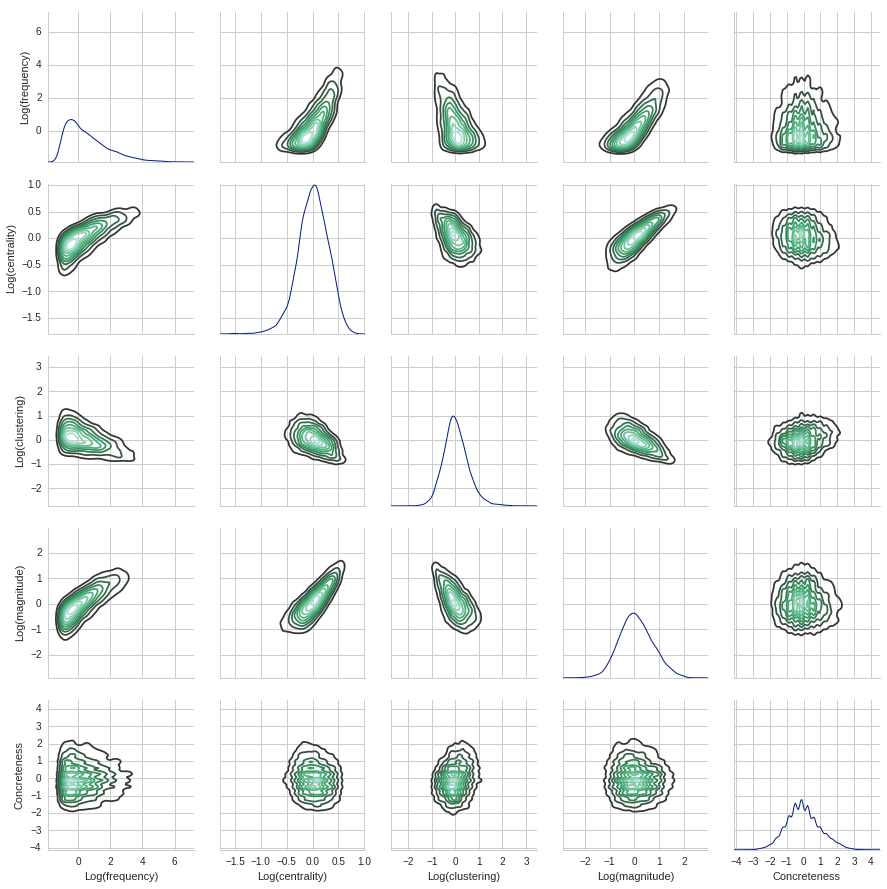

In [890]:
# Bivariate dist. between main predictors
plt.rcParams["figure.figsize"] = (8,8)
g = sns.PairGrid(vis_df, vars=[u'Log(frequency)', u'Log(centrality)', u'Log(clustering)', u'Log(magnitude)', u'Concreteness'])
g.map_diag(sns.kdeplot, lw=1, legend=False)
g.map_offdiag(sns.kdeplot, color='black')
plt.savefig("var-rel.pdf")

In [321]:
# build ablated models for visualization
ablated_lmms = {}
feats = ["freq + I(freq**2.0)", "clust", "centr", "con_s + I(con_s**2.0)", "extent"]
formula = "vol ~ {} + adj + adv + verb + C(year)"
for ablated_feat in feats:
    active_feats = [feat for feat in feats if feat != ablated_feat]
    ablated_formula = formula.format(" + ".join(active_feats))
    ablated_lmms[ablated_feat] = mixedmodels.run_lmm(ablated_formula, train_df, groups=train_df["word"], reml=True)

/afs/cs.stanford.edu/u/wleif/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/afs/cs.stanford.edu/u/wleif/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/afs/cs.stanford.edu/u/wleif/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/afs/cs.stanford.edu/u/wleif/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/afs/cs.stanford.edu/u/wleif/anaconda/lib/python2.7/site-packages/st

In [250]:
for feat in feats:
    print feat, mixedmodels.like_ratio(ablated_lmms[feat], diff_res)

NameError: name 'feats' is not defined

In [885]:
vis_df.columns

Index([u'adj', u'adv', u'centr', u'clust', u'con', u'con_s', u'disp',
       u'extent', u'freq', u'freq_diff', u'freq_type', u'noun', u'verb',
       u'vol', u'word', u'year'],
      dtype='object')

In [889]:
indices = np.random.choice(len(train_df), 10000)
vis_df = train_df.iloc[indices]
vis_df.columns = [u'adj', u'adv', u'Log(centrality)', u'Log(clustering)', u'con', u'Concreteness', u'disp',
       u'Log(magnitude)', u'Log(frequency)', u'freq_diff', u'freq_type', u'noun', u'verb',
       u'vol', u'word', u'year']

In [96]:
# Different functions for getting bootstrap CIs
def get_bootstrap_k(x, y, grid, nboot=10, bootsize=10000, bwselectsize=1000):
    boot_res = []
    indices =np.random.choice(len(x), bwselectsize)
    bwreg = sm.nonparametric.KernelReg(y[indices], x[indices], var_type='c', bw='aic')
    for i in range(nboot):
        if bootsize != None:
            indices =np.random.choice(len(x), bootsize)
        else:
            indices = np.random.choice(len(x), len(x))
        kreg = sm.nonparametric.KernelReg(y[indices], x[indices], var_type='c', bw=bwreg.bw)
        res, _ = kreg.fit(data_predict=grid)
        boot_res.append(res)
    return boot_res

def get_ablated_bootstrap_k(ablated_mods, feat, nboot=10, bootsize=5000, grid=None):
    x = np.mat(noreg_train_df[feat.split("+")[0].strip()].as_matrix()).T
    res = ablated_lmms[feat]
    y = res.model.endog - np.dot(res.model.exog, res.fe_params.as_matrix()) + np.mean(train_df["vol"])
    if grid == None:
        grid = np.linspace(np.percentile(x, 1), np.percentile(x, 99), num=100)
    return grid, get_bootstrap_k(x, y, grid, nboot=nboot, bootsize=bootsize)

def make_bootstrap_ci(boots, alpha):
    boot_arr = np.array(boots)
    boot_means = np.mean(boots, axis=0)
    boot_lows = np.percentile(boots, alpha/2.0 * 100, axis=0)
    boot_highs = np.percentile(boots, (1-alpha/2.0) * 100, axis=0)
    return boot_means, boot_highs, boot_lows

In [322]:
freqgrid, freqboot = get_ablated_bootstrap_k(ablated_lmms, 'freq + I(freq**2.0)', nboot=1000, bootsize=10000)

In [323]:
centrgrid, centrboot = get_ablated_bootstrap_k(ablated_lmms, "centr", nboot=1000, bootsize=10000)

In [324]:
clustgrid, clustboot = get_ablated_bootstrap_k(ablated_lmms, "clust", nboot=1000, bootsize=10000)

In [325]:
congrid, conboot = get_ablated_bootstrap_k(ablated_lmms, "con_s + I(con_s**2.0)", nboot=1000, bootsize=10000)

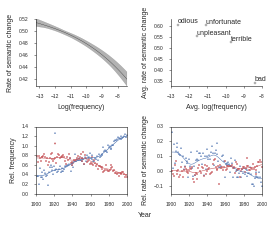

In [583]:
plt.rcParams["figure.figsize"] = (3.9, 3)
s= 2
fig, axs = plt.subplots(2,2)
freq_info = make_bootstrap_ci(freqboot, 0.001)
axs[0,0].plot(freqgrid, freq_info[0], lw=0.25, color='black')
axs[0,0].fill_between(freqgrid, freq_info[1], freq_info[2], alpha=0.3, color='black')
axs[0,0].set_xlabel("Log(frequency)")
axs[0,0].set_ylabel("Rate of semantic change")
axs[0,0].locator_params(nbins=6, tight=True)
axs[0,0].locator_params(axis="y", nbins=7, tight=True)
sns.despine(ax=axs[0,0])
for axis in ['top','bottom','left','right']:
    axs[0,0].spines[axis].set_linewidth(0.6)
ablated_lmm = ablated_lmms["freq + I(freq**2.0)"]
plot_words(words, noreg_train_df, "freq", "vol", ablated_lmm, axs[0,1])
axs[0,1].set_xlim(-13, -8)
axs[0,1].locator_params(nbins=6, tight=True)
axs[0,1].locator_params(axis="y", nbins=8, tight=True)
axs[0,1].set_xlabel("Avg. log(frequency)")
axs[0,1].set_ylabel("Avg. rate of semantic change")
for axis in ['top','bottom','left','right']:
    axs[0,1].spines[axis].set_linewidth(0.6)
sns.despine(ax=axs[0,1])
a = plothelper.plot_smooth(np.arange(1901, 2001), vol_series("stupid"), color=sns.color_palette()[0], ax=axs[1,1], marker='^', s=s, lw=0.5)
b = plothelper.plot_smooth(np.arange(1901, 2001), vol_series("dull"), color=sns.color_palette()[2], ax=axs[1,1], s=s, lw=0.5)
#c = plothelper.plot_smooth(np.arange(1902, 2001), vol_series("queer"), color=sns.color_palette()[1], ax=axs[0]),
axs[1,0].set_xlim(1900, 2000)
axs[1,1].set_xlim(1900, 2000)
axs[1,0].legend((a,b), ["", ""], loc=(0.1, 0.65))
a = plothelper.plot_smooth(np.arange(1901, 2001), freq_series("stupid"), color=sns.color_palette()[0], ax=axs[1,0], marker='^', s=s, lw=0.6)
b = plothelper.plot_smooth(np.arange(1901, 2001), freq_series("dull"), color=sns.color_palette()[2], ax=axs[1,0], s=s,lw=0.5)
axs[1,0].set_ylabel("Rel. frequency")
axs[1,1].set_ylabel("Rel. rate of semantic change")
fig.text(0.5, 0, "Year", fontsize=7)
#axs[0].set_xlabel("Year")
#axs[1].set_xlabel("Year")
for axis in ['top','bottom','left','right']:
    for subplot in [0,1]:
        axs[1,subplot].spines[axis].set_linewidth(0.6)
axs[1,1].xaxis.set_ticks_position('bottom')
axs[1,1].yaxis.set_ticks_position('left')
axs[1,0].xaxis.set_ticks_position('bottom')
axs[1,0].yaxis.set_ticks_position('left')
plt.tight_layout()
plt.savefig("freqplots.pdf")

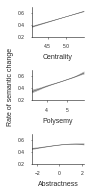

In [524]:
sns.set_context("paper", font_scale=0.57)
sns.set_style("white")
plt.rcParams["lines.linewidth"] = 0.25
plt.rcParams["patch.linewidth"] = 0.25
plt.rcParams["grid.linewidth"] = 0.6
plt.rcParams["axes.linewidth"] = 0.6
plt.rcParams["axes.labelsize"] =  7
plt.rcParams["axes.titlesize"] = 7
plt.rcParams["xtick.labelsize"] = 5
plt.rcParams["ytick.labelsize"] = 5
plt.rcParams["ytick.major.size"] = 1.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 1.5
plt.rcParams["xtick.major.width"] = 0.5
#plt.rcParams["ytick.minor.size"] = 10
#plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["legend.fontsize"] = 7
sns.set_palette("dark")
plt.rcParams["figure.figsize"] = (1.22, 2.8)
fig, axs = plt.subplots(3,1, sharey=True)
#freq_info = make_bootstrap_ci(freqboot, 0.001)
#axs[0,0].plot(freqgrid, freq_info[0], lw=1.5)
#axs[0,0].fill_between(freqgrid, freq_info[1], freq_info[2], alpha=0.3)
#axs[0,0].set_xlabel("Log(Frequency)")
centr_info = make_bootstrap_ci(centrboot, 0.001)
axs[0].plot(centrgrid, centr_info[0], color="black")
axs[0].fill_between(centrgrid, centr_info[1], centr_info[2], alpha=0.3, color="black")
axs[0].set_xlabel("Centrality")
axs[0].locator_params(nbins=3, tight=True)
axs[0].set_xticks(axs[0].get_xticks()[1:-1])
clust_info = make_bootstrap_ci(clustboot, 0.001)
axs[1].plot(-1*clustgrid, clust_info[0], color="black")
axs[1].fill_between(-1*clustgrid, clust_info[1], clust_info[2], alpha=0.3, color="black")
axs[1].set_xlabel("Polysemy")
axs[1].locator_params(nbins=5, tight=True)
con_info = make_bootstrap_ci(conboot, 0.001)
axs[2].plot(-1*congrid, con_info[0], color="black")
axs[2].fill_between(-1*congrid, con_info[1], con_info[2], alpha=0.3, color="black")
axs[2].set_xlabel("Abstractness")
plt.ylim(0.2,0.7)
fig.text(0.00, 0.55, 'Rate of semantic change', va='center', rotation='vertical', size=7)
axs[2].locator_params(nbins=4, tight=True)
plt.tight_layout()
for axis in ['top','bottom','left','right']:
    for subplot in [0,1,2]:
        axs[subplot].spines[axis].set_linewidth(0.6)
    
sns.despine()
plt.savefig("kerneltrends.pdf")

In [876]:
# FROM HERE AND BELOW IS SI.3 simiulation code

freqs = np.random.choice(train_df["freq"], 1000)
freqs = np.exp(freqs)
freqs = freqs/freqs.sum()

In [1033]:
co = np.random.choice(train_df["freq"], 100, replace=False)
co = co/co.sum()
co -= 10**-9.0
np.random.multinomial(1000, co)

array([19,  0, 11,  0, 10,  9,  0,  0,  0, 19,  7, 35, 63, 21,  0,  0,  0,
        4,  0, 48, 56,  0,  0, 36,  0, 57, 70, 33,  6,  0, 31,  0, 15,  0,
        0, 17, 87, 13,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,
        0, 11, 14,  7,  2, 32,  5,  0,  0,  0,  0,  0,  0,  0, 13, 41, 14,
       19, 14,  0,  0,  2,  8,  3, 16,  9, 12,  0,  3, 12, 11, 19,  0, 12,
        0,  0,  0, 25,  1, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [34]:
def get_avg_cos(n, co_n):
    diffs = []
  #  co = np.random.choice(np.exp(noreg_train_df["freq"]), co_n, replace=False)
    for i in range(0, 10000):
        co = np.random.rand(co_n)
        co2 = np.zeros(len(co))
        for i,entry in enumerate(co):
            co2[i] += entry
        co = co2/(co2.sum())
        np.random.multinomial(n, co)
        new_draw = np.log(np.random.multinomial(n, co)+1)
        old_draw = np.log(np.random.multinomial(n, co)+1)
        diff = new_draw.dot(old_draw) / (np.linalg.norm(old_draw) * np.linalg.norm(new_draw))
        diffs.append(diff)
    return np.mean(diffs), np.std(diffs)

In [45]:
xs_s = np.logspace(1, 3, num=10, base=10)
ys_s = np.logspace(2, 4, num=10, base=10)
xs = []
ys = []
zs = []
szs = []
for x in xs_s:
    xs_i = []
    ys_i = []
    zs_i = []
    szs_i = []
    for y in ys_s:
        m, s = get_avg_cos(y,x)
        szs_i.append(s)
        zs_i.append(m)
        xs_i.append(x)
        ys_i.append(y)
    xs.append(xs_i)
    ys.append(ys_i)
    zs.append(zs_i)
    szs.append(szs_i)

In [36]:
zs_m = []
szs_m = []
ys_m = np.logspace(2, 4, num=50, base=10)
for y in ys_m:
    m, s = get_avg_cos(y,np.sqrt(y))
    szs_m.append(s)
    zs_m.append(m)

In [225]:
1-np.array(zs_m)

array([ 0.02188537,  0.01947343,  0.01774475,  0.01604683,  0.0182482 ,
        0.01655291,  0.01413393,  0.01323526,  0.01054494,  0.01449978,
        0.01185443,  0.00885672,  0.0094298 ,  0.00771083,  0.00884685,
        0.00648784,  0.00677357,  0.00560612,  0.00696209,  0.00596384,
        0.00665462,  0.00664564,  0.00569578,  0.00529718,  0.00341581,
        0.00435219,  0.00369171,  0.00435214,  0.00413821,  0.00311675,
        0.00288831,  0.00353365,  0.00293332,  0.00259593,  0.0027905 ,
        0.0026238 ,  0.00182219,  0.00216782,  0.00243493,  0.00158151,
        0.00207527,  0.00211957,  0.00141431,  0.00167036,  0.00141698,
        0.00114632,  0.00102438,  0.0014327 ,  0.00090777,  0.00141527])

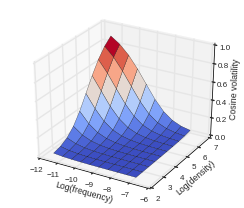

In [46]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (3.5, 3)
sns.set_style("white")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(xs, ys)
ax.plot_surface(np.log(np.array(ys)/(10**7.0)), np.log(np.array(xs)), 1-np.array(zs),rstride=1, cstride=1, cmap=cm.coolwarm)
ax.set_zlim(0.0, 1.0)
ax.set_ylabel("Log(density)")
ax.set_xlabel("Log(frequency)")
ax.set_zlabel("Cosine volatility")
plt.tight_layout()
plt.savefig("freqvol-sim-3d.pdf")

In [211]:
y_mat = np.array(ys)
x_mat = np.array(xs)
z_mat = np.array(zs)
sz_mat = np.array(szs)

array([[   10.        ,    10.        ,    10.        ,    10.        ,
           10.        ,    10.        ,    10.        ,    10.        ,
           10.        ,    10.        ],
       [   16.68100537,    16.68100537,    16.68100537,    16.68100537,
           16.68100537,    16.68100537,    16.68100537,    16.68100537,
           16.68100537,    16.68100537],
       [   27.82559402,    27.82559402,    27.82559402,    27.82559402,
           27.82559402,    27.82559402,    27.82559402,    27.82559402,
           27.82559402,    27.82559402],
       [   46.41588834,    46.41588834,    46.41588834,    46.41588834,
           46.41588834,    46.41588834,    46.41588834,    46.41588834,
           46.41588834,    46.41588834],
       [   77.42636827,    77.42636827,    77.42636827,    77.42636827,
           77.42636827,    77.42636827,    77.42636827,    77.42636827,
           77.42636827,    77.42636827],
       [  129.1549665 ,   129.1549665 ,   129.1549665 ,   129.1549665 ,
   

In [547]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='deg ~ freq + C(year)', data=noreg_train_df)
res = mod.fit()
res.summary()

KeyboardInterrupt: 

In [ ]:
sp.stats.pearsonr(np.exp(train_df

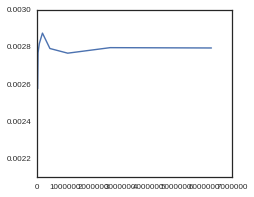

In [212]:
plt.plot(np.diag(y_mat), 1-np.diag(z_mat))

In [1096]:
sz_mat/np.sqrt(1000)

array([[  1.16460802e-03,   7.44781153e-04,   3.78438267e-04,
          2.50096405e-04,   1.36400627e-04,   7.45911433e-05,
          5.18943770e-05,   3.11575933e-05,   1.42339905e-05,
          1.55660257e-05],
       [  1.27884081e-03,   8.39039784e-04,   5.72664145e-04,
          2.87934661e-04,   1.64888409e-04,   1.06965177e-04,
          5.86685366e-05,   3.96653638e-05,   2.50351374e-05,
          1.53222645e-05],
       [  1.50387357e-03,   1.06163769e-03,   6.33947807e-04,
          4.27263744e-04,   2.52540463e-04,   1.51188087e-04,
          9.20675617e-05,   5.60535669e-05,   3.27315820e-05,
          2.09304264e-05],
       [  1.50540044e-03,   1.18431572e-03,   8.36809021e-04,
          5.16988392e-04,   3.25907607e-04,   1.77300083e-04,
          1.03098352e-04,   6.65065724e-05,   3.73195504e-05,
          2.14012309e-05],
       [  1.50418715e-03,   1.14569177e-03,   9.26018758e-04,
          5.99604779e-04,   3.98521536e-04,   2.47511978e-04,
          1.48198715e-04

In [270]:
plt.rcParams["font.sans-serif"].insert(0, u"Helvetica")

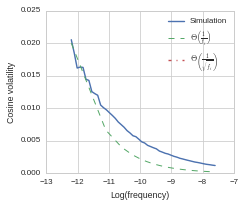

In [538]:
sns.set_context("paper")
plt.rcParams["figure.figsize"] = (3.5, 3)
sns.set_style("whitegrid")
#plt.plot(y_mat[0,:],1-z_mat[0,:], color="black", lw=1)
temp1 = np.linspace(100, 10000.0, num=50)
temp2 = np.linspace(100, 10000.0, num=50)
plt.plot(np.log(ys_m/(2*10**7.0)), 1-np.array(zs_m))
plt.fill_between(np.log(ys_m/(2*10**7.0)), 1-np.array(zs_m)-np.array(szs_m)/100, 1-np.array(zs_m)+np.array(szs_m)/100,  alpha=0.1)
plt.plot(np.log(temp1/(2*10**7.0)), 2/temp2, ls='--', lw=1)
plt.plot(np.log(temp1/(2*10**7.0)), 0.172/np.sqrt(np.log(temp1/(2*10**7.0))), ls='-.')
plt.legend(["Simulation", r"$\Theta\left(\frac{1}{f_i}\right)$", r"$\Theta\left(\frac{1}{\sqrt{f_i}}\right)$"])
plt.xlabel("Log(frequency)")
plt.ylabel("Cosine volatility")
plt.tight_layout()
plt.savefig("freqvol-sim-2d.pdf")

In [551]:
sp.stats.pearsonr(1/np.log(ys_m),1-np.array(zs_m))[0]**2.0

0.96900926734918691

In [544]:
np.log(1-np.array(zs_m)[0])

-3.8865035399018755

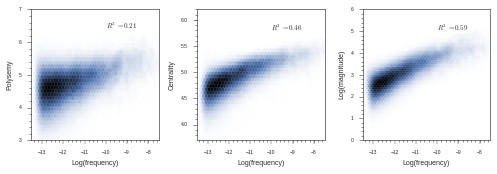

In [537]:
# Correlation between frequency and other predictors
import matplotlib.colors
sns.set_palette("deep")
def _freedman_diaconis_bins(a):
    a = np.asarray(a)
    h = 2 * sns.iqr(a) / (len(a) ** (1 / 3))
    if h == 0:
        return np.sqrt(a.size)
    else:
        return np.ceil((a.max() - a.min()) / h)
def my_hex(x_data, y_data, gridsize=60):
    sns.set_palette("deep")
    color = sns.color_palette()[0]
    color_rgb = matplotlib.colors.colorConverter.to_rgb(color)
    colors = [sns.set_hls_values(color_rgb, l=l) for l in np.linspace(1, 0, 12)]
    cmap = sns.blend_palette(colors, as_cmap=True)
    plt.hexbin(x_data, y_data, gridsize = gridsize, cmap=cmap)
#sns.set_style("white")
plt.rcParams["lines.linewidth"] = 0.25
plt.rcParams["patch.linewidth"] = 0.25
plt.rcParams["grid.linewidth"] = 0.6
plt.rcParams["axes.linewidth"] = 0.6
plt.rcParams["axes.labelsize"] =  7
plt.rcParams["axes.titlesize"] = 7
plt.rcParams["xtick.labelsize"] = 5
plt.rcParams["ytick.labelsize"] = 5
plt.rcParams["ytick.major.size"] = 4
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 4
plt.rcParams["xtick.major.width"] = 0.4
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["legend.fontsize"] = 7
plt.rcParams["figure.figsize"] = (7, 2.5)
ax = plt.subplot(1,3,1)
g = my_hex(noreg_train_df["freq"], -1*noreg_train_df["clust"])
plt.xlim(-13.5, -7.5)
plt.ylim(3, 7)
plt.gca().axes.get_yaxis().set_ticks(np.arange(3,8))
plt.xlabel("Log(frequency)")
plt.ylabel("Polysemy")
plt.text(-10, 6.4, '$R^2 = %0.2f$' % sp.stats.pearsonr(noreg_train_df["freq"], -1*noreg_train_df["clust"])[0] ** 2, fontsize=7)
ax.minorticks_on()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax = plt.subplot(1,3,2)
g = my_hex(noreg_train_df["freq"], noreg_train_df["centr"])
plt.xlim(-13.5, -7.5)
plt.ylim(3.7, 6.2)
plt.xlabel("Log(frequency)")
plt.ylabel("Centrality")
plt.text(-10, 5.8, '$R^2 = %0.2f$' % sp.stats.pearsonr(noreg_train_df["freq"], noreg_train_df["centr"])[0] ** 2, fontsize=7)
ax.minorticks_on()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax = plt.subplot(1,3,3)
g = my_hex(noreg_train_df["freq"], noreg_train_df["extent"])
plt.xlim(-13.5, -7.5)
plt.ylim(0, 6)
plt.xlabel("Log(frequency)")
plt.ylabel("Log(magnitude)")
plt.text(-10, 5, '$R^2 = %0.2f$' % sp.stats.pearsonr(noreg_train_df["freq"], noreg_train_df["extent"])[0] ** 2, fontsize=7)
ax.minorticks_on()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()
plt.savefig("freq-covar-corr.pdf", transparent=True)